In [1]:
import sys
import os

import pandas as pd
import numpy as np

from string import ascii_uppercase


import rasterio as rio

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import metrics

import glob
import tqdm

from subprocess import Popen

%matplotlib inline

# Vegetation Mask Comparisions

In [2]:
root = "/Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/CO/"

In [3]:
vegmask = os.path.join(root, "veg/GE_veg_1m.tif")

In [4]:
image_dirs = glob.glob(os.path.join(root, "s3:::*"))

In [15]:
image_dirs

['/Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/CO/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-V2-2020-03-03-17-49-47-260:planet-snowcover-imagery:20180524_172142_103d_3B_AnalyticMS_SR_clip',
 '/Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/CO/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-V2-2020-03-03-17-49-47-260:planet-snowcover-imagery:20180524_172143_103d_3B_AnalyticMS_SR_clip',
 '/Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/CO/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-V2-2020-03-03-17-49-47-260:planet-snowcover-imagery:20180524_172144_103d_3B_AnalyticMS_SR_clip',
 '/Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/CO/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-V2-2020-03-03-17-49-47-260:planet-snowcover-imagery:20180524_172145_103d_3B_AnalyticMS_SR_clip',
 '/Volumes/wrangell-st-elias/research/planet/tuol-reruns-v2/CO/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-2018060

## Clip veg to individual images

In [16]:
gdal_clip = "gdalwarp -overwrite -dstnodata 9999 -t_srs EPSG:4326 -cutline {cutline} -crop_to_cutline {vegmask} {vegmask_clipped}"
for image_root in image_dirs:
    gdal_clip_cmd = gdal_clip.format(
        cutline = os.path.join(image_root, 'data-mask.geojson'),
        vegmask = vegmask,
        vegmask_clipped = os.path.join(image_root, 'veg_mask_clipped.vrt')
    )
    Popen(gdal_clip_cmd, shell=True).communicate()


## Resample + Clip all Metrics in all Images

In [17]:
gdal_combine = "gdalbuildvrt -overwrite -resolution lowest " \
               "-separate -r {resampling} -vrtnodata '-9999 -9999 -9999' " \
               "{output}.vrt {comparator} {aso} {veg}"
        

In [18]:
# for each image, need to build {pred, aso, pred} file at coarsest resolution.
all_results = []
aso_glob = "*/ASO_merged.tif"
comparators_glob = [
    ('ml', "*/*SR_clip_merged.tif"),
    ('s2', "*/*NDSI*.tif"),
    ('ls8', "*/LC08*.tif")
]
for image_root in tqdm.tqdm(image_dirs):
    imageid = os.path.split(image_root)[1].split(':')[-1]
    os.makedirs(os.path.join(root, image_root, "veg"), exist_ok=True)
    aso = glob.glob(os.path.join(root, image_root, aso_glob))[0]
    for kind, comparator in comparators_glob:
        raw_comparator = glob.glob(os.path.join(root, image_root, comparator))[0]
        outfile =  os.path.join(root, image_root, "veg", f"{kind}_aso_veg")
        combine_command = gdal_combine.format(
            resampling = 'nearest',
            output = outfile, 
            aso = aso, 
            comparator = raw_comparator, 
            veg = os.path.join(root, image_root, "veg_mask_clipped.vrt")
        )
        
        Popen(combine_command, shell=True).communicate()
        
        comparator_combined = rio.open(outfile+'.vrt')
        _comparator_data = comparator_combined.read(1, masked=True)
        _aso_data = comparator_combined.read(2, masked=True)
        _vegmask_data = comparator_combined.read(3, masked=True)
        
        ## Comparator Veg + NoVeg (+nodata) Masking
        comp_nodata = rio.open(raw_comparator).nodata
        comp_veg_on_nodata_mask = (
            (_vegmask_data.data == 0) |
            (_aso_data.mask) |
            (_comparator_data.data == comp_nodata)
        ).astype(bool)
        comp_veg = _comparator_data.copy()
        comp_veg.mask = comp_veg_on_nodata_mask
        comp_veg_off_nodata_mask = (
            (_vegmask_data.data == 1) | 
            (_aso_data.mask) | 
            (_comparator_data.data == comp_nodata)
        ).astype(bool)
        comp_noveg = _comparator_data.copy()
        comp_noveg.mask = comp_veg_off_nodata_mask
        
        ## ASO Veg + NoVeg (+nodata) Masking (For reference; coarsened.)
        aso_veg_on_nodata_mask = (
            (_vegmask_data.data == 0) | 
            (_aso_data.mask) | 
            (_comparator_data.data == comp_nodata)
        ).astype(bool)
        aso_veg = _aso_data.copy()
        aso_veg.mask = aso_veg_on_nodata_mask
        aso_veg_off_nodata_mask = (
            (_vegmask_data.data == 1) | 
            (_aso_data.mask) | 
            (_comparator_data.data == comp_nodata)
        ).astype(bool)
        aso_noveg = _aso_data.copy()
        aso_noveg.mask = aso_veg_off_nodata_mask
    

        
        ## comparison
        true_veg, comp_veg = aso_veg[~aso_veg.mask].data, comp_veg[~comp_veg.mask].data
        performance_veg = metrics.precision_recall_fscore_support(true_veg, comp_veg, average='binary')
        accuracy_veg = metrics.balanced_accuracy_score(true_veg, comp_veg)
        
        true_noveg, comp_noveg = aso_noveg[~aso_noveg.mask].data, comp_noveg[~comp_noveg.mask].data
        performance_noveg = metrics.precision_recall_fscore_support(true_noveg, comp_noveg, average='binary')
        accuracy_noveg = metrics.balanced_accuracy_score(true_noveg, comp_noveg)
        
        ## combine for comparator
        combined_veg = pd.DataFrame.from_records(
            [list(performance_veg[:3]) + [accuracy_veg]], 
            columns = ['Precision', 'Recall', 'F-Score', 'Balanced Accuracy']
        ).assign(type='Vegetation Only', imageid=imageid)
        combined_noveg = pd.DataFrame.from_records(
            [list(performance_noveg[:3]) + [accuracy_noveg]], 
            columns = ['Precision', 'Recall', 'F-Score', 'Balanced Accuracy']
        ).assign(type='No Vegetation', imageid=imageid)
        
        combined = pd.melt(
            pd.concat([combined_veg, combined_noveg]),
            id_vars = ['type', 'imageid'], 
            value_vars = ['Precision', 'Recall', 'F-Score', 'Balanced Accuracy']
        ).assign(comparator=kind)
        
        all_results.append(combined)
        

        
        
        
    
        
        

100%|██████████| 12/12 [04:21<00:00, 21.76s/it]


In [19]:
all_results_df = pd.concat(all_results)

In [20]:
all_results_df

,type,imageid,variable,value,comparator
0,Vegetation Only,20180524_172142_103d_3B_AnalyticMS_SR_clip,Precision,0.948836,ml
1,No Vegetation,20180524_172142_103d_3B_AnalyticMS_SR_clip,Precision,0.965667,ml
2,Vegetation Only,20180524_172142_103d_3B_AnalyticMS_SR_clip,Recall,0.768801,ml
3,No Vegetation,20180524_172142_103d_3B_AnalyticMS_SR_clip,Recall,0.856818,ml
4,Vegetation Only,20180524_172142_103d_3B_AnalyticMS_SR_clip,F-Score,0.849383,ml
...,...,...,...,...,...
3,No Vegetation,20180524_172637_0f2d_3B_AnalyticMS_SR_clip,Recall,0.913689,ls8
4,Vegetation Only,20180524_172637_0f2d_3B_AnalyticMS_SR_clip,F-Score,0.802420,ls8
5,No Vegetation,20180524_172637_0f2d_3B_AnalyticMS_SR_clip,F-Score,0.916164,ls8
6,Vegetation Only,20180524_172637_0f2d_3B_AnalyticMS_SR_clip,Balanced Accuracy,0.830117,ls8


In [6]:
savepath = os.path.join(root, "veg/veg_comparison_allimages.csv")
# all_results_df.to_csv(savepath)

## Plotting

In [7]:
if os.path.exists(savepath):
    if input("Load existing? [y/n]: ") == 'y':
        all_results_df = pd.read_csv(savepath)

Load existing? [y/n]:  y


In [11]:
all_results_df = all_results_df.replace({
    'ls8' : "Landsat 8 fSCA", 
    's2' : "Sentinel-2 NDSI", 
    'ml' : "CubeSat ML"
}).rename({
    'comparator' : "SCA"
}, axis=1)

In [20]:
all_results_df.groupby([
    'SCA', 'type', 'variable'
]).apply(
    lambda x: pd.Series([np.mean(x.value), np.std(x.value)])
).rename({
    0: 'Mean',
    1: 'Std. Dev.'
}, axis=1).round(2).to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th></th>\n      <th></th>\n      <th>Mean</th>\n      <th>Std. Dev.</th>\n    </tr>\n    <tr>\n      <th>SCA</th>\n      <th>type</th>\n      <th>variable</th>\n      <th></th>\n      <th></th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th rowspan="8" valign="top">CubeSat ML</th>\n      <th rowspan="4" valign="top">No Vegetation</th>\n      <th>Balanced Accuracy</th>\n      <td>0.83</td>\n      <td>0.06</td>\n    </tr>\n    <tr>\n      <th>F-Score</th>\n      <td>0.82</td>\n      <td>0.09</td>\n    </tr>\n    <tr>\n      <th>Precision</th>\n      <td>0.88</td>\n      <td>0.06</td>\n    </tr>\n    <tr>\n      <th>Recall</th>\n      <td>0.77</td>\n      <td>0.13</td>\n    </tr>\n    <tr>\n      <th rowspan="4" valign="top">Vegetation Only</th>\n      <th>Balanced Accuracy</th>\n      <td>0.68</td>\n      <td>0.08</td>\n    </tr>\n    <tr>\n      <th>F-Score</th>\n      

In [24]:
one_image = all_results_df[all_results_df.imageid.str.contains("20180524_172637_0f2d")]

In [25]:
all_results_df = one_image

(0, 1)

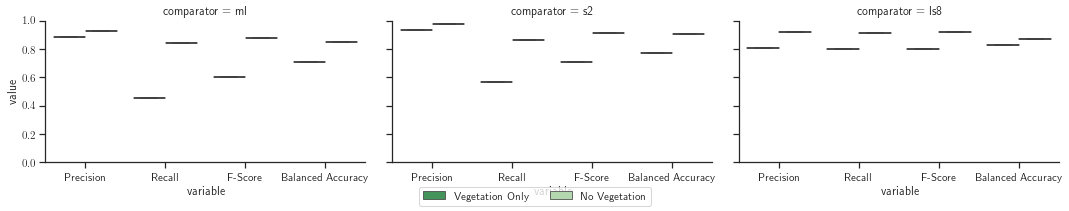

In [26]:
sns.set(style='ticks')
# plt.rc('text', usetex=True)


retval = sns.catplot(x='variable', y='value', hue='type', kind='box', col='comparator', data=all_results_df, hue_order=['Vegetation Only', "No Vegetation"], palette='Greens_r', dodge=True, height=3, aspect=1.5)
sns.despine()
h,l = retval.axes[0][0].get_legend_handles_labels()
retval._legend.remove()
retval.fig.legend(h,l, ncol=2, loc='lower center') # you can specify any location parameter you want here
# plt.savefig("comparator_veg.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
# retval.fig.add_axes([0, 0, 0.2, 0.2])
plt.ylim([0, 1])

In [27]:
all_results_df = all_results_df.replace({
    'ls8' : "Landsat 8 fSCA", 
    's2' : "Sentinel-2 NDSI", 
    'ml' : "CubeSat ML"
}).rename({
    'comparator' : "SCA"
}, axis=1)

In [28]:
colors = [
    "tab:green", # veg,
    "tab:brown",
    "tab:orange"
    #     'grey'#     cm.Greens(0.3), # veg,

]
cmap = sns.color_palette(colors)

In [29]:
resolutions = {
    "CubeSat ML" : "3 m",
    "Sentinel-2 NDSI": "10 m",
    "Landsat 8 fSCA": "30 m"
}

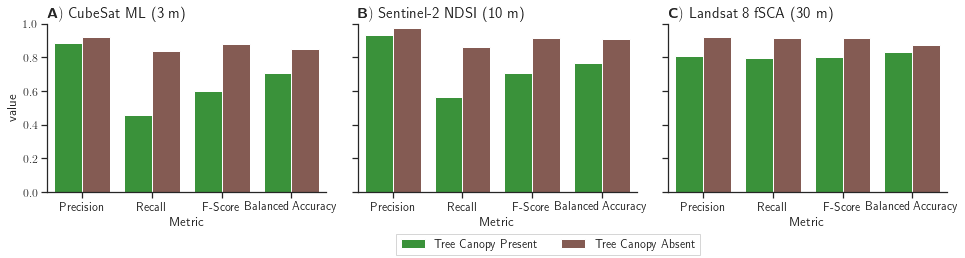

In [37]:
import matplotlib 
import seaborn as sns
sns.set(style='ticks', font_scale=1.1)
# sns.set(font_scale=1.7, style='ticks')

matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
plot = sns.catplot(x='variable', y='value', hue='type', kind='bar', ci='sd', col='SCA', data=all_results_df,
                     col_order=["CubeSat ML", "Sentinel-2 NDSI", "Landsat 8 fSCA"], 
                     hue_order=['Vegetation Only', "No Vegetation"],
                     palette=cmap, 
                     height=3, aspect=1.5, capsize=0.1, errwidth=1)

[ax.set_xlabel("Metric") for ax in list(plot.axes)[0]]
h,l = plot.axes[0][0].get_legend_handles_labels()
l = [
    r"Tree Canopy Present",
    r"Tree Canopy Absent",
]
plot._legend.remove()
plot.fig.legend(h,l, ncol=3, loc='center', bbox_to_anchor=(0.5,0.05), frameon=True, fancybox=False) # you can specify any location parameter you want here

# plot.set_titles(template='')
for i, ax in enumerate(plot.axes[0]):
    title = ax.get_title().split(" = ")[1]
    ax.set_title(r"$\textbf{" + ascii_uppercase[i] + r"})$ " + f"{title} (" + resolutions[title] + ")", loc='left', fontsize=15)
plot.set_titles(template='')

plot.set(ylim=[0, 1])

plot.fig.set_figheight(plot.fig.bbox_inches.bounds[3] + 0.7)
# plt.tight_layout()
plt.savefig("co_comparator_veg_one.png", dpi=300, bbox_inches='tight', )



In [18]:
all_results_df.to_csv(os.path.join(root, "veg/veg_comparison_allimages.csv"))

In [29]:
all_results_df


,type,variable,value,SCA
0,Vegetation Only,Precision,0.948836,CubeSat ML
1,No Vegetation,Precision,0.965667,CubeSat ML
2,Vegetation Only,Recall,0.768801,CubeSat ML
3,No Vegetation,Recall,0.856818,CubeSat ML
4,Vegetation Only,F-Score,0.849383,CubeSat ML
...,...,...,...,...
3,No Vegetation,Recall,0.913689,Landsat 8 fSCA
4,Vegetation Only,F-Score,0.802420,Landsat 8 fSCA
5,No Vegetation,F-Score,0.916164,Landsat 8 fSCA
6,Vegetation Only,Balanced Accuracy,0.830117,Landsat 8 fSCA


In [48]:
percentages = []
for image_root in tqdm.tqdm(image_dirs):
    raw_comparator = os.path.join(image_root, "veg", "ml_aso_veg.vrt")
    comparator_combined = rio.open(raw_comparator)
    _comparator_data = comparator_combined.read(1, masked=True)
    _aso_data = comparator_combined.read(2, masked=True)
    _vegmask_data = comparator_combined.read(3, masked=True)
    
    _, (nd, noveg_count, veg_count) = np.unique(_vegmask_data.data, return_counts=True)
    percentages.append(veg_count / (noveg_count + veg_count))


100%|██████████| 12/12 [01:15<00:00,  6.28s/it]


In [53]:
percentages[-1]

0.5486367133797911